Download TabNet

In [1]:
!pip -q install /kaggle/input/tabnet/pytorch_tabnet-4.1.0-py3-none-any.whl

Import libraries

In [2]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from sklearn.base import clone, BaseEstimator, RegressorMixin
from sklearn.metrics import cohen_kappa_score, accuracy_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.callbacks import Callback

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

SEED = 42
n_splits = 5

Feature engineering

In [3]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    data_tensor = torch.FloatTensor(df_scaled)
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

LBS_TO_KG = 0.453592
IN_TO_CM = 2.54

activity_factors = {1: 1.2, 2: 1.375, 3: 1.55, 4: 1.725, 5: 1.9}

def feature_engineering(df):
    
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    
    df['PAQ_Total'] = df['PAQ_C-PAQ_C_Total'].combine_first(df['PAQ_A-PAQ_A_Total'])
    
    df.drop(columns=[
    'PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total', 'BIA-BIA_Fat', 
    'BIA-BIA_BMI','BIA-BIA_BMR','BIA-BIA_DEE'], inplace=True)

    df['BMR'] = df.apply(
        lambda row: (
            88.362 + (13.397 * (row['Physical-Weight'] * LBS_TO_KG)) +
            (4.799 * (row['Physical-Height'] * IN_TO_CM))
            if row['Basic_Demos-Sex'] == 0 else
            447.593 + (9.247 * (row['Physical-Weight'] * LBS_TO_KG)) +
            (3.098 * (row['Physical-Height'] * IN_TO_CM))
        ),
        axis=1
    )

    df['BIA-BIA_Activity_Level_num'] = df['BIA-BIA_Activity_Level_num'].apply(
        lambda x: 1 if x <= 1.5 else
                  2 if x <= 2.5 else
                  3 if x <= 3.5 else
                  4 if x <= 4.5 else
                  5
    )

    df['FGC-FGC_CU_Zone'] = df['FGC-FGC_CU_Zone'].apply(
        lambda x: 0 if x <= 0.5 else
                  1
    )

    df['FGC-FGC_GSND_Zone'] = df['FGC-FGC_GSND_Zone'].apply(
        lambda x: 1 if x <= 1.5 else
                  2 if x <= 2.5 else
                  3
    )

    df['FGC-FGC_GSD_Zone'] = df['FGC-FGC_GSD_Zone'].apply(
        lambda x: 1 if x <= 1.5 else
                  2 if x <= 2.5 else
                  3
    )

    df['FGC-FGC_PU_Zone'] = df['FGC-FGC_PU_Zone'].apply(
        lambda x: 0 if x <= 0.5 else
                  1
    )

    df['FGC-FGC_SRL_Zone'] = df['FGC-FGC_SRL_Zone'].apply(
        lambda x: 0 if x <= 0.5 else
                  1
    )

    df['FGC-FGC_SRR_Zone'] = df['FGC-FGC_SRR_Zone'].apply(
        lambda x: 0 if x <= 0.5 else
                  1
    )

    df['FGC-FGC_TL_Zone'] = df['FGC-FGC_TL_Zone'].apply(
        lambda x: 0 if x <= 0.5 else
                  1
    )

    df['BIA-BIA_Frame_num'] = df['BIA-BIA_Frame_num'].apply(
        lambda x: 1 if x <= 1.5 else
                  2 if x <= 2.5 else
                  3
    )

    df['PreInt_EduHx-computerinternet_hoursday'] = df['PreInt_EduHx-computerinternet_hoursday'].apply(
        lambda x: 0 if x <= 0.5 else
                  1 if x <= 1.5 else
                  2 if x <= 2.5 else
                  3
    )

    df['TDEE'] = df.apply(
        lambda row: row['BMR'] * activity_factors[row['BIA-BIA_Activity_Level_num']],
        axis=1
    )
    
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['Fat_Percentage'] =(df['BIA-BIA_FMI'] / df['Physical-Weight']) * 100
    df['BMI_Muscle'] =  df['Physical-BMI'] * df['BIA-BIA_SMM']
    df['Activity_Level_BMI'] = df['Physical-BMI'] / df['BIA-BIA_Activity_Level_num']
    df['BMI_Fat_Percentage'] = df['Physical-BMI'] * df['Fat_Percentage']
    df['Fat_Percentage_Activity_Level'] =  df['Fat_Percentage'] / df['BIA-BIA_Activity_Level_num']
    df['Muscle_Fat_Percentage'] = df['BIA-BIA_SMM'] / (df['Fat_Percentage'] / 100)
    df['Fat_Percentage_Internet_Hours'] = df['Fat_Percentage'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['Weight_Internet_Hours'] = df['Physical-Weight'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['CGAS_Age'] = df['CGAS-CGAS_Score'] * df['Basic_Demos-Age'] 
    df['CGAS_BMI'] = df['CGAS-CGAS_Score'] * df['Physical-BMI']
    
    return df

In [4]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

Custom TabNet

In [5]:
class TabNetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = TabNetRegressor(**kwargs)
        self.kwargs = kwargs
        self.imputer = SimpleImputer(strategy='median')
        self.best_model_path = 'best_tabnet_model.pt'
        
    def fit(self, X, y):
        X_imputed = self.imputer.fit_transform(X)
            
        if hasattr(y, 'values'):
            y = y.values

        X_train, X_valid, y_train, y_valid = train_test_split(X_imputed, y, test_size=0.2, random_state=SEED)

        history = self.model.fit(
            X_train = X_train,
            y_train = y_train.reshape(-1, 1),
            eval_set = [(X_valid, y_valid.reshape(-1, 1))],
            eval_name = ['valid'],
            eval_metric = ['mse'],
            max_epochs = 200,
            patience = 20,
            batch_size = 1024,
            virtual_batch_size = 128,
            num_workers = 0,
            drop_last = False,
            callbacks = [
                TabNetPretrainedModelCheckpoint(
                    filepath = self.best_model_path,
                    monitor = 'valid_mse',
                    mode = 'min',
                    save_best_only = True,
                    verbose = True
                )
            ]
        )

        if os.path.exists(self.best_model_path):
            self.model.load_model(self.best_model_path)
            os.remove(self.best_model_path)

        return self

    def predict(self, X):
        X_imputed = self.imputer.transform(X)
        return self.model.predict(X_imputed).flatten()

    def __deepcopy__(self, memo):
        cls = self.__class__
        result = self.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))

        return result

In [6]:
class TabNetPretrainedModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else -float('inf')
        
    def on_train_begin(self, logs=None):
        self.model = self.trainer
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        
        if (self.mode == 'min' and current < self.best) or (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            if self.save_best_only:
                self.model.save_model(self.filepath)

Train function

In [7]:
def Train(voting_model, test):
    X = train.drop(['sii'], axis=1)
    y = train['sii']
    
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
        
    train_S = []
    test_S = []
        
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test), n_splits))
    
    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
    
        model = clone(voting_model)
        model.fit(X_train, y_train)
    
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
    
        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded
    
        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)
    
        train_S.append(train_kappa)
        test_S.append(val_kappa)
            
        test_preds[:, fold] = model.predict(test)
            
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)
    
    print(f"Mean Train QWK: {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK: {np.mean(test_S):.4f}")
    
    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
        
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)
    
    print(f"Optimized QWK: {tKappa:.3f}")
    
    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
        
    Submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    final_model = clone(voting_model)
    final_model.fit(X, y)
    
    return Submission, final_model

In [8]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

train_ts_encoded = perform_autoencoder(df_train, encoding_dim=60, epochs=100, batch_size=32)
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=60, epochs=100, batch_size=32)

time_series_cols = train_ts_encoded.columns.tolist()
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

train = pd.merge(train, train_ts_encoded, how="left", on='id')
test = pd.merge(test, test_ts_encoded, how="left", on='id')

100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


Epoch [10/100], Loss: 1.6505]
Epoch [20/100], Loss: 1.5217]
Epoch [30/100], Loss: 1.4773]
Epoch [40/100], Loss: 1.4856]
Epoch [50/100], Loss: 1.4603]
Epoch [60/100], Loss: 1.4442]
Epoch [70/100], Loss: 1.4201]
Epoch [80/100], Loss: 1.3928]
Epoch [90/100], Loss: 1.3612]
Epoch [100/100], Loss: 1.3591]
Epoch [10/100], Loss: 1.0297]
Epoch [20/100], Loss: 0.6961]
Epoch [30/100], Loss: 0.4278]
Epoch [40/100], Loss: 0.4271]
Epoch [50/100], Loss: 0.4271]
Epoch [60/100], Loss: 0.4271]
Epoch [70/100], Loss: 0.4271]
Epoch [80/100], Loss: 0.4271]
Epoch [90/100], Loss: 0.4271]
Epoch [100/100], Loss: 0.4271]


Data Pre-processing

In [9]:
imputer = KNNImputer(n_neighbors=5)
numeric_cols = train.select_dtypes(include=['int32', 'int64', 'float64', 'int64']).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]
        
train = train_imputed

train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)

In [10]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [11]:
featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 
                'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW',
                'PAQ_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

extraCols = ['BMI_Internet_Hours','Fat_Percentage', 'BMI_Muscle',
             'Fat_Percentage_Activity_Level','Fat_Percentage_Internet_Hours',
             'Weight_Internet_Hours','Muscle_Fat_Percentage','BMR','TDEE','Internet_Hours_Age',
             'CGAS_Age','CGAS_BMI', 'BMI_Age']

featuresCols += extraCols

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

featuresCols.remove('sii')

test = test[featuresCols]

In [12]:
if np.any(np.isinf(train)):
    train = train.replace([np.inf, -np.inf], np.nan)

Models Parameters

In [13]:
LGBM_Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  
    'lambda_l2': 0.01, 
    'device': 'cpu',
}


XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  
    'reg_lambda': 5,
    'random_state': SEED,
    'tree_method': 'gpu_hist'
}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 10,
    'task_type': 'GPU',
}

TabNet_Params = {
    'n_d': 64,            
    'n_a': 64,       
    'n_steps': 5,         
    'gamma': 1.5,        
    'n_independent': 2,  
    'n_shared': 2,       
    'lambda_sparse': 1e-4,  
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
    'mask_type': 'entmax',
    'scheduler_params': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
    'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose': 1,
    'device_name': 'cuda' if torch.cuda.is_available() else 'cpu'
}

Light = LGBMRegressor(**LGBM_Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)
TabNet_Model = TabNetWrapper(**TabNet_Params)

voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model),
    ('tabnet', TabNet_Model),
], weights=[4.0,4.0,4.5,4.0])

Train ensemble model

In [14]:
Submission1, fitted_voting_model = Train(voting_model, test)

Training Folds: 100%|██████████| 5/5 [01:16<00:00, 15.30s/it]

Mean Train QWK: 0.7136
Mean Validation QWK: 0.4568
Optimized QWK: 0.522


epoch 0  | loss: 1.74342 | valid_mse: 4.57467 |  0:00:00s

Epoch 0: valid_mse improved from inf to 4.5747
Successfully saved model at best_tabnet_model.pt.zip
epoch 1  | loss: 0.98533 | valid_mse: 5.72239 |  0:00:00s
epoch 2  | loss: 0.73076 | valid_mse: 3.56948 |  0:00:00s

Epoch 2: valid_mse improved from 4.5747 to 3.5695
Successfully saved model at best_tabnet_model.pt.zip
epoch 3  | loss: 0.6887  | valid_mse: 3.1328  |  0:00:00s

Epoch 3: valid_mse improved from 3.5695 to 3.1328
Successfully saved model at best_tabnet_model.pt.zip
epoch 4  | loss: 0.6326  | valid_mse: 1.68529 |  0:00:01s

Epoch 4: valid_mse improved from 3.1328 to 1.6853
Successfully saved model at best_tabnet_model.pt.zip
epoch 5  | loss: 0.60215 | valid_mse: 1.94001 |  0:00:01s
epoch 6  | loss: 0.54753 | valid_mse: 2.56659 |  0:00:01s
epoch 7  | loss: 0.53241 | valid_mse: 5.48228 |  0:00:01s
epoch 8  | loss: 0.5035  | valid_mse: 3.31734 |  0:00:01s
epoch 9  | loss: 0.47754 | valid_mse: 0.95113 |  0:00:02s

Epoch 

Feature Importances

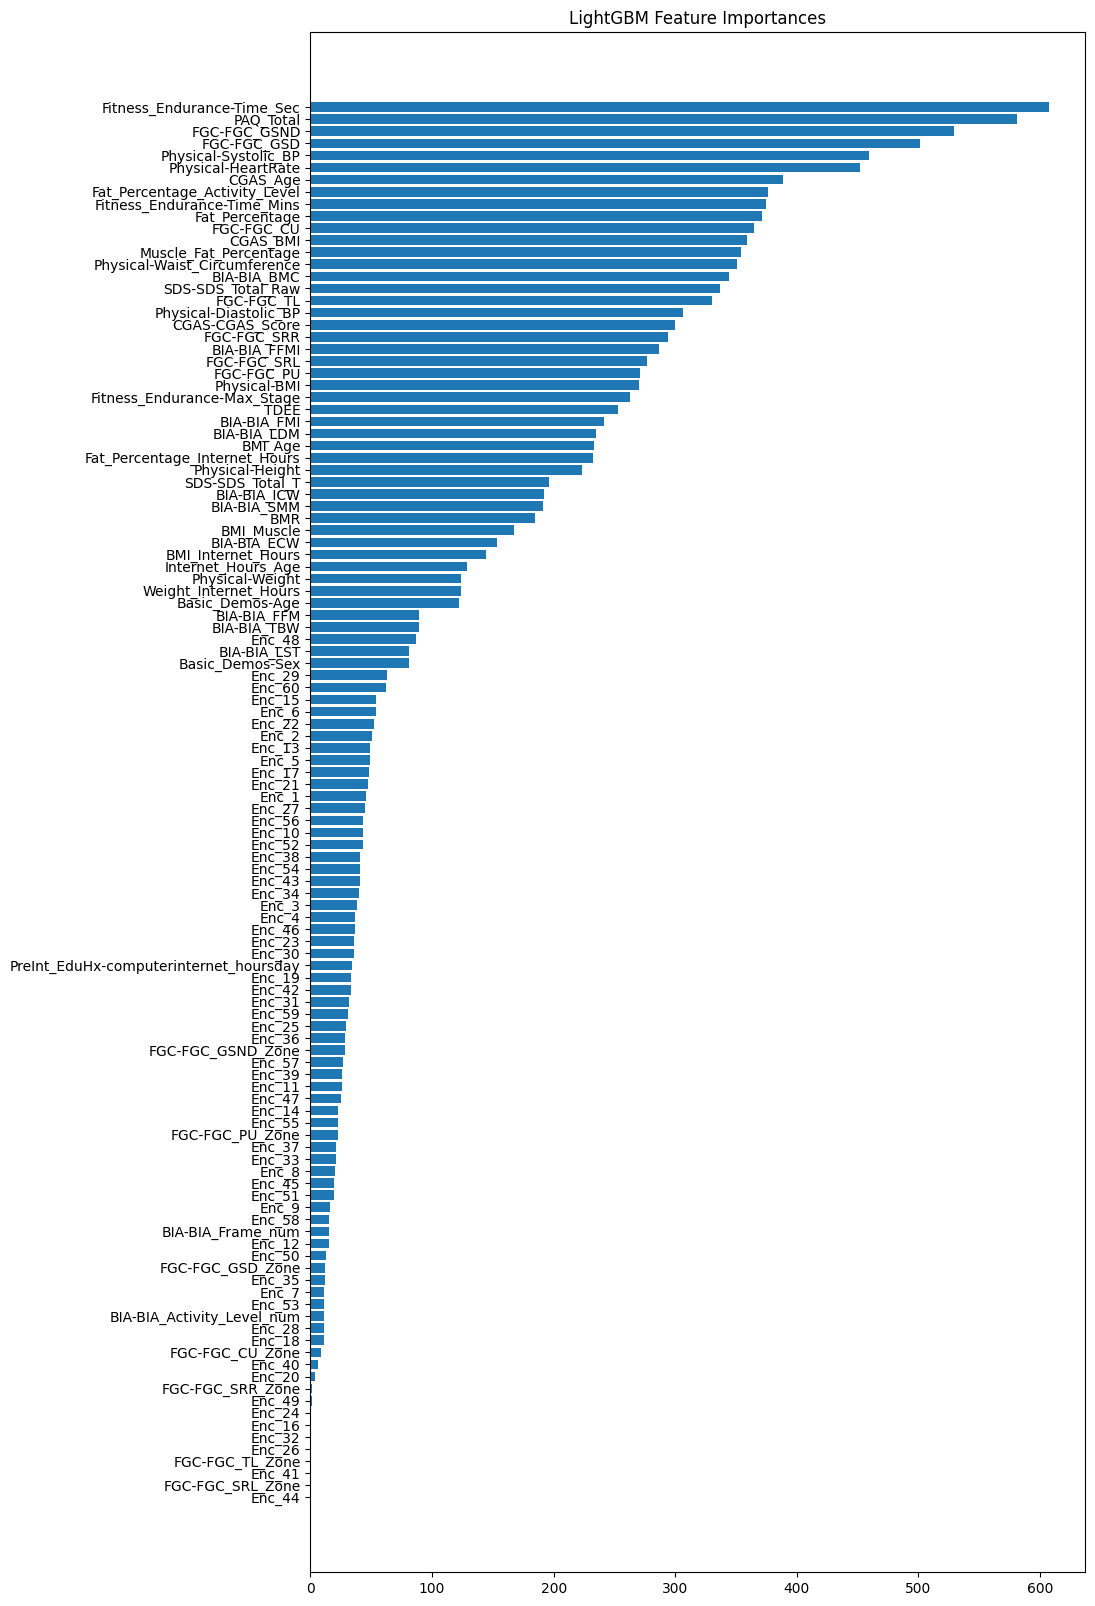

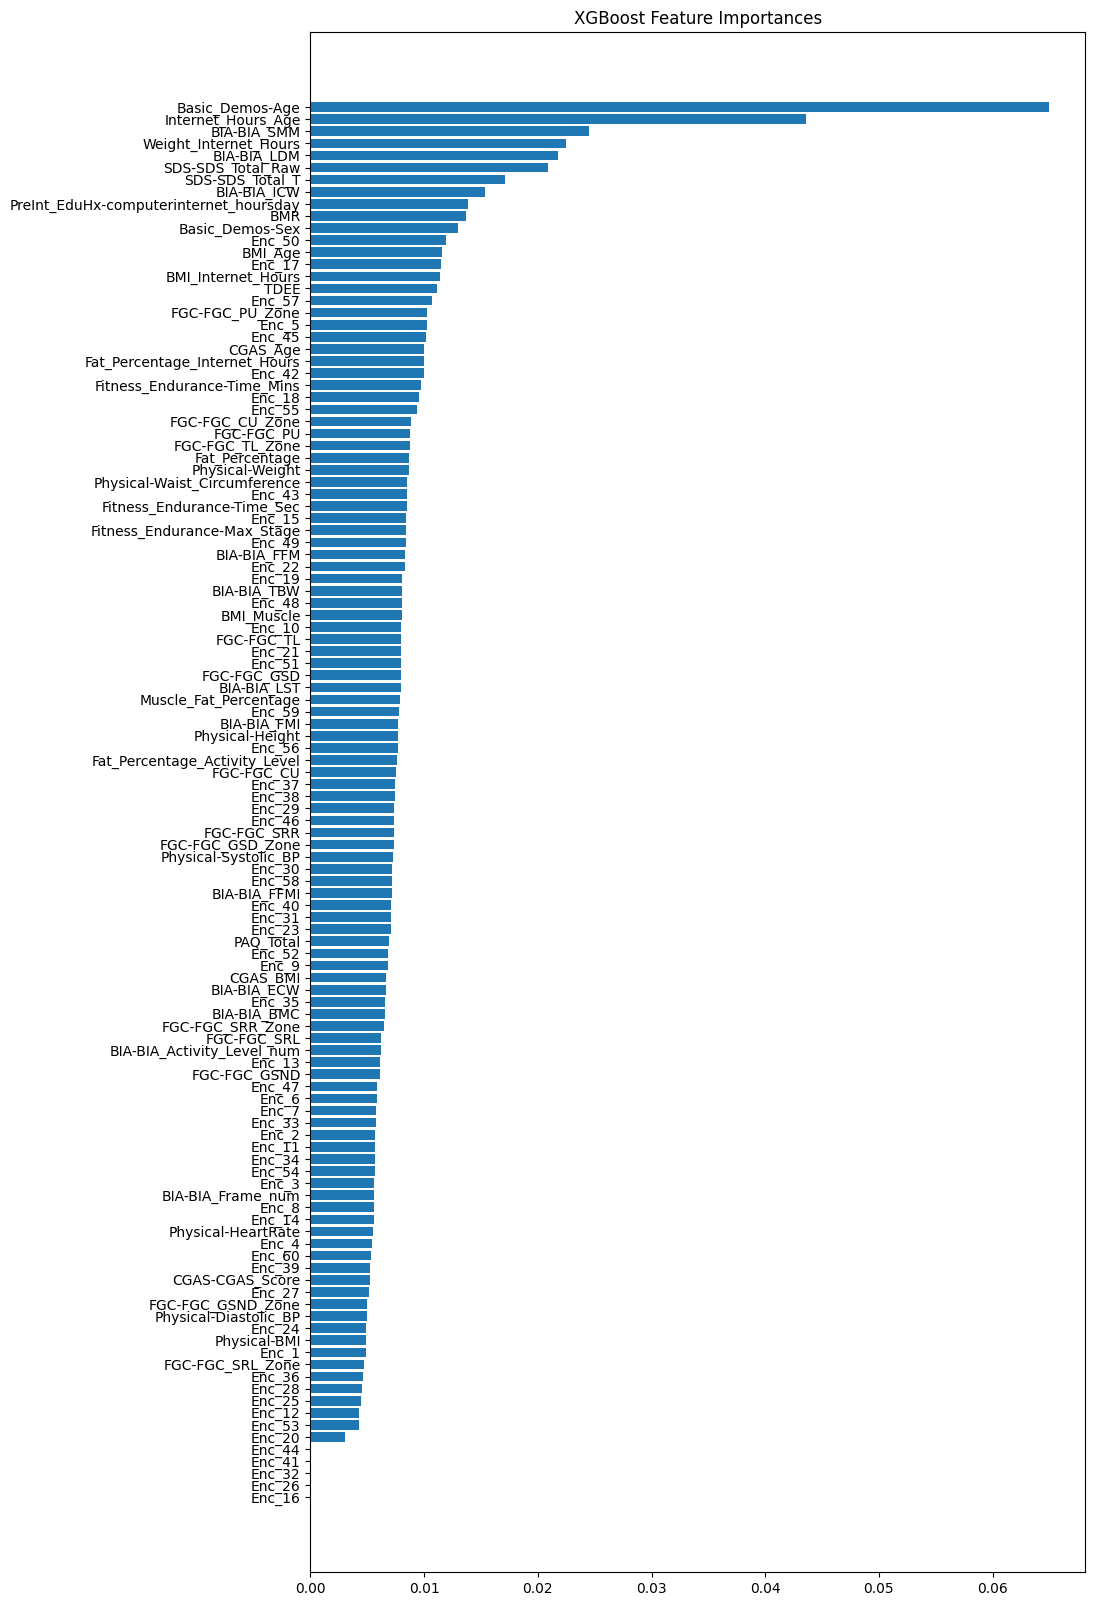

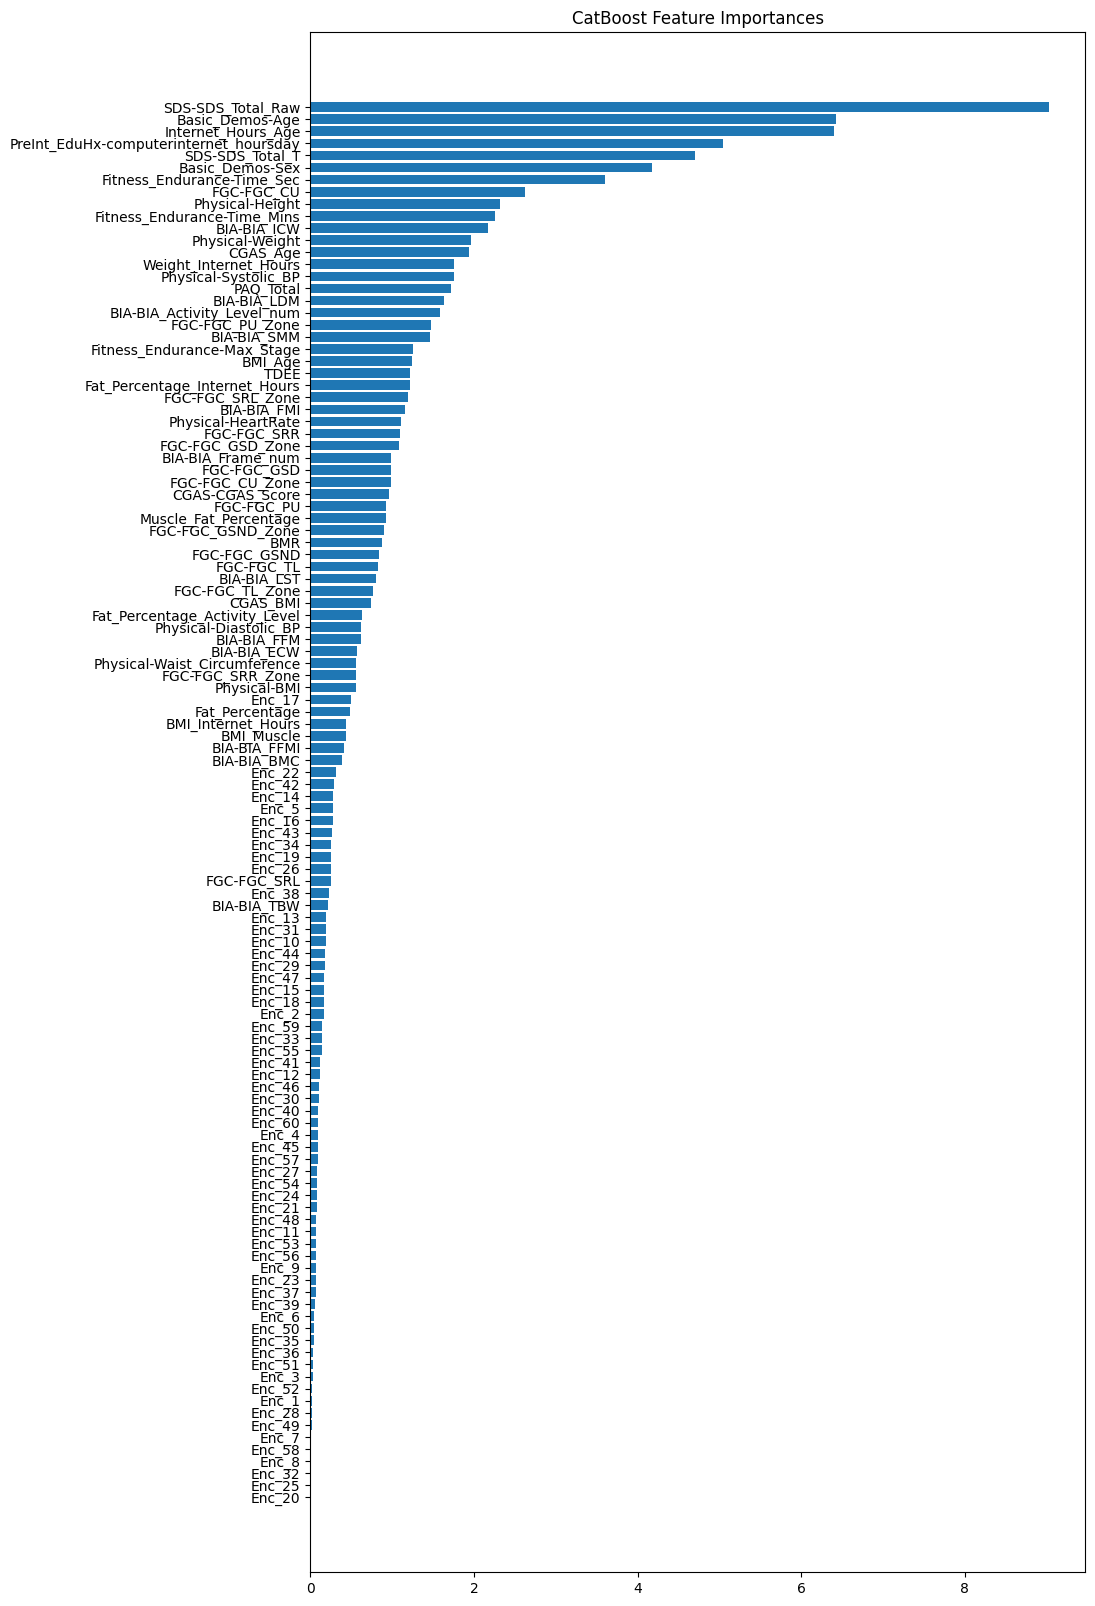

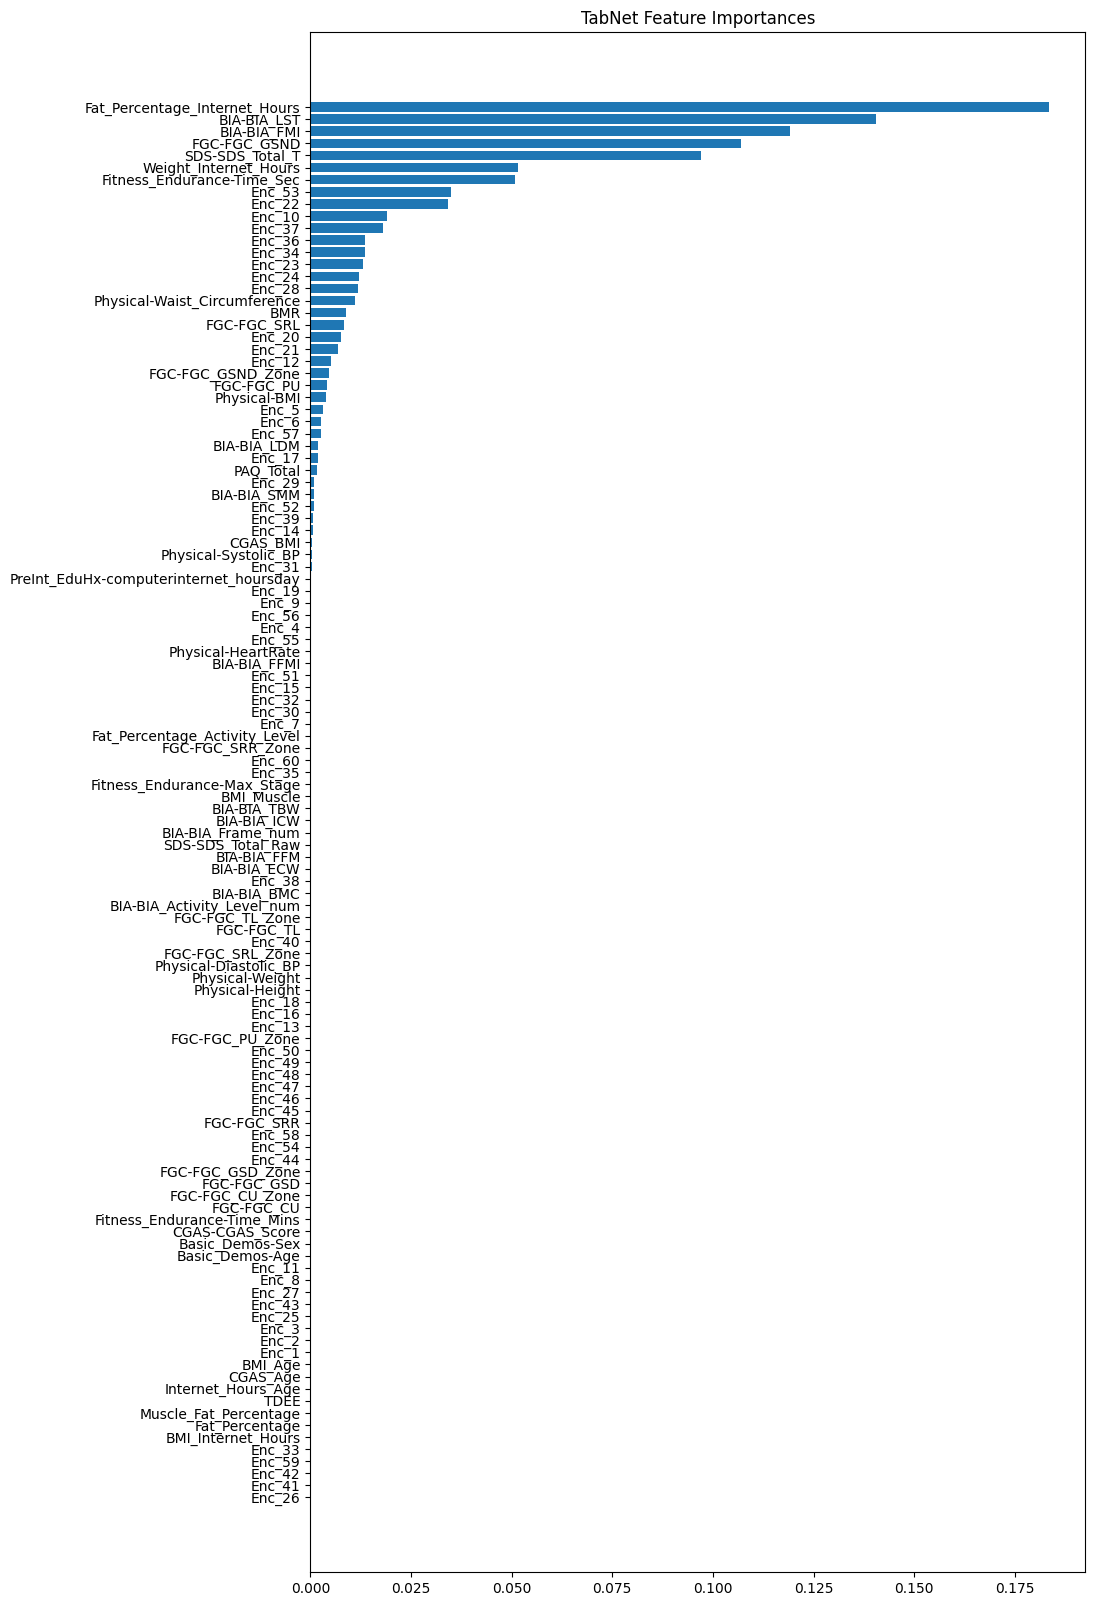

In [15]:
LGBM_model = fitted_voting_model.estimators_[0]
XGB_model = fitted_voting_model.estimators_[1]
CatBoost_model = fitted_voting_model.estimators_[2]
TabNet_model = fitted_voting_model.estimators_[3]

features = featuresCols 

lgbm_importances = LGBM_model.feature_importances_
sorted_idx = np.argsort(lgbm_importances)
plt.figure(figsize=(10, 20))
plt.barh(np.array(features)[sorted_idx], lgbm_importances[sorted_idx])
plt.title("LightGBM Feature Importances")
plt.show()

xgb_importances = XGB_model.feature_importances_
sorted_idx = np.argsort(xgb_importances)
plt.figure(figsize=(10, 20))
plt.barh(np.array(features)[sorted_idx], xgb_importances[sorted_idx])
plt.title("XGBoost Feature Importances")
plt.show()

cat_importances = CatBoost_model.get_feature_importance()
cat_importances = np.array(cat_importances)
sorted_idx = np.argsort(cat_importances)
plt.figure(figsize=(10, 20))
plt.barh(np.array(features)[sorted_idx], cat_importances[sorted_idx])
plt.title("CatBoost Feature Importances")
plt.show()

tabnet_importances = TabNet_model.model.feature_importances_
tabnet_importances = np.array(tabnet_importances)
sorted_idx = np.argsort(tabnet_importances)
plt.figure(figsize=(10, 20))
plt.barh(np.array(features)[sorted_idx], tabnet_importances[sorted_idx])
plt.title("TabNet Feature Importances")
plt.show()

In [16]:
Submission1

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,1
7,0068a485,1
8,0069fbed,1
9,0083e397,1


Second ensemble model

In [17]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)   

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
         'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season',
         'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

100%|██████████| 2/2 [00:00<00:00, 12.77it/s]


In [18]:
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  
    'lambda_l2': 0.01 
}

XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1, 
    'reg_lambda': 5, 
    'random_state': SEED
}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10 
}

Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model),
])

In [19]:
Submission2, fitted_voting_model = Train(voting_model, test)

Training Folds: 100%|██████████| 5/5 [00:49<00:00,  9.91s/it]

Mean Train QWK: 0.7595
Mean Validation QWK: 0.3926


Optimized QWK: 0.457


In [20]:
Submission2

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,0


Third ensemble model

In [21]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)   

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')


cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
         'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season',
         'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

100%|██████████| 2/2 [00:00<00:00, 12.63it/s]


In [22]:
imputer = SimpleImputer(strategy='median')

voting_model = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(random_state=SEED))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(random_state=SEED))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(random_state=SEED, silent=True))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(random_state=SEED))])),
    ('gb', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(random_state=SEED))])),
])

In [23]:
Submission3, fitted_voting_model = Train(voting_model, test)

Training Folds: 100%|██████████| 5/5 [01:57<00:00, 23.56s/it]

Mean Train QWK: 0.9175
Mean Validation QWK: 0.3803


Optimized QWK: 0.450
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24233
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 150
[LightGBM] [Info] Start training from score 0.580409


In [24]:
Submission3

,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,0


Final voting

In [25]:
sub1 = Submission1
sub2 = Submission2
sub3 = Submission3

sub1 = sub1.sort_values(by='id').reset_index(drop=True)
sub2 = sub2.sort_values(by='id').reset_index(drop=True)
sub3 = sub3.sort_values(by='id').reset_index(drop=True)

combined = pd.DataFrame({
    'id': sub1['id'],
    'sii_1': sub1['sii'],
    'sii_2': sub2['sii'],
    'sii_3': sub3['sii']
})

def majority_vote(row):
    return row.mode()[0]

combined['final_sii'] = combined[['sii_1', 'sii_2', 'sii_3']].apply(majority_vote, axis=1)

final_submission = combined[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})

final_submission.to_csv('submission.csv', index=False)

In [26]:
final_submission

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,0
